In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import implicit
from implicit.datasets.movielens import get_movielens
from implicit.evaluation import leave_k_out_split
from implicit.evaluation import ndcg_at_k
from implicit.als import AlternatingLeastSquares

from interpret.glassbox import ExplainableBoostingRegressor


# MovieLens Dataset

In [3]:
def get_users_by_usage(ratings_df):
    labels = list(range(1, 8))
    popularity_cut = pd.qcut(ratings_df.groupby('user_id').movie_id.nunique(), 7)
    popularity_cut = popularity_cut.cat.rename_categories(labels)
    popularity_cut = pd.DataFrame(popularity_cut)
    popularity_cut = popularity_cut.reset_index(drop=False)
    popularity_cut.columns = ['user_id', 'usage']

    popularity_cut_counts = pd.DataFrame(popularity_cut.groupby('usage').count())
    popularity_cut_counts = popularity_cut_counts.reset_index(drop=False)
    popularity_cut_counts['percentage'] = popularity_cut_counts.user_id / popularity_cut_counts.user_id.sum()

    return popularity_cut, popularity_cut_counts

In [4]:
def get_divided_test_fold(ratings_df, test_index, sampling_rate=.2):
    test_fold_df = ratings_df[ratings_df.user_id.isin(test_index)].copy()
    test_df = test_fold_df.groupby('user_id').sample(frac=.2)
    test_fold_df.loc[test_fold_df.user_id.isin(test_df.user_id), 'rating'] = 0
    
    return test_fold_df, test_df

In [5]:
def get_metric_dict(users, column, values=None):
    metric_dict = {}
    if not values:
        values = users[column].unique()
    for g in values:
        metric_dict[g] = []
    return metric_dict

In [6]:
def get_age_bins():
    age_bins = {}
    age_bins[1] = '1-17'
    age_bins[18] = '18-24'
    age_bins[25] = '25-34'
    age_bins[35] = '35-44'
    age_bins[45] = '45-49'
    age_bins[50] = '50-55'
    age_bins[56] = '56+'

    age_labels = list(age_bins.values())

    return age_bins, age_labels

In [94]:
def get_user_df_for_ebm(ratings, test_test_df, k=1000):
    user_ids = []
    ndcgs = []
    col = 'user_id'
    for a in test_test_df[col].unique():
        user_ids.append(a)
        test_data = ratings[test_test_df[test_test_df[col] == a].user_id.unique()]
        ndcgs.append(ndcg_at_k(model, train_data, test_data, K=k, show_progress=False))

    ndcg_df = pd.DataFrame({'user_id': user_ids, 'ndcg': ndcgs})

    users_test_df = users[users.user_id.isin(user_ids)] 
    users_test_df = users_test_df.merge(ndcg_df, how='right', on='user_id')
    users_test_df['last_digit'] = users_test_df.user_id.apply(lambda x: str(x)[-1])

    train_cols = users_test_df.columns.difference(['user_id', 'ndcg', 'occupation', 'zip-code'])

    return users_test_df, train_cols

## Preparation

In [95]:
variant = "1m"

titles, ratings = get_movielens(variant)
ratings = ratings.T

col_names = ["user_id", "movie_id", "rating", "matrix_position"]
ratings_df = pd.read_csv('./ml-1m/ratings.dat', delimiter='::', names=col_names, engine='python')

col_names = ['user_id', 'gender', 'age', 'occupation', 'zip-code']
users = pd.read_csv('./ml-1m/users.dat', delimiter='::', names=col_names, engine='python')

In [96]:
popularity_cut, popularity_cut_counts = get_users_by_usage(ratings_df)
age_bins, age_labels = get_age_bins()

In [97]:
users = users.merge(popularity_cut, how='left', on='user_id')
users = users[users.columns.difference(['occupation', 'zip-code'])].copy()

In [91]:
users

,age,gender,usage,user_id
0,1,F,3,1
1,56,M,5,2
2,25,M,3,3
3,45,M,1,4
4,25,M,6,5
...,...,...,...,...
6035,25,F,7,6036
6036,45,F,6,6037
6037,56,F,1,6038
6038,45,F,5,6039


## CV

In [98]:
ndcg_dict_age = get_metric_dict(users, 'age')
ndcg_dict_gender = get_metric_dict(users, 'gender')
ndcg_dict_usage = get_metric_dict(users, '', values=range(1, 8))

In [99]:
ndcg_dicts = {}
ebm_dicts = {}
for d in [ndcg_dicts, ebm_dicts]:
    d['age'] = get_metric_dict(users, 'age')
    d['gender'] = get_metric_dict(users, 'gender')
    d['usage'] = get_metric_dict(users, '', values=range(1, 8))

In [100]:
random_state=12345
n_splits=5

In [101]:
# divide ratings into 5 CV
# 0th column is 0, since user ids start with 1
kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(ratings)):
    print(f'Starting ALS training num. {i}...')
    # train data is divided into two parts
    # in train_index, full user data is used for training
    # in test_index, 80% of user data is used for training and the rest 20% is used for testing
    test_train_df, test_test_df = get_divided_test_fold(ratings_df, test_index)

    train_data = ratings.copy()
    # blend out the 20% of test users data for testing
    # test data contains data used for training + 20% blended in train data
    train_data[test_test_df.user_id, test_test_df.movie_id] = 0

    # ALS model
    model = AlternatingLeastSquares(factors=50, regularization=0.01)
    model.fit(train_data)
    print(f'ALS model trained, starting EBM training...')

    test_test_df = test_test_df.merge(users, how='left', on='user_id')
    # test_test_df = test_test_df.merge(popularity_cut, how='left', on='user_id')

    print(f'EBM model trained, starting evaluation...')

    # EBM model
    # train and test EBM on test fold since we use NDCG as dependent variable and NDCG from users from test set is probably significantly better than for users from test set
    users_test_df, train_cols = get_user_df_for_ebm(ratings, test_test_df, k=1000)
    X_train, X_test, y_train, y_test = train_test_split(users_test_df[train_cols], users_test_df['ndcg'], test_size=0.2, random_state=random_state)

    ebm = ExplainableBoostingRegressor(random_state=random_state)
    ebm.fit(X_train, y_train)
    

    for col, ndcg_dict in ndcg_dicts.items():
        print(f'Starting evaluation by {col} groups...')
        for a in test_test_df[col].unique():
            test_data = ratings[test_test_df[test_test_df[col] == a].user_id.unique()]
            ndcg_dict[a].append(ndcg_at_k(model, train_data, test_data, K=1000, show_progress=False))

            ebm_X_test = X_test[X_test[col] == a]
            ebm_y_test = y_test[y_test.index.isin(ebm_X_test.index)]
            ebm_dicts[col][a].append(ebm.score(ebm_X_test, ebm_y_test))


        print(f'Evaluation by {col} finished...')
        

Starting ALS training num. 0...


  0%|          | 0/15 [00:00<?, ?it/s]

ALS model trained, starting EBM training...
EBM model trained, starting evaluation...
Starting evaluation by age groups...
Evaluation by age finished...
Starting evaluation by gender groups...
Evaluation by gender finished...
Starting evaluation by usage groups...
Evaluation by usage finished...
Starting ALS training num. 1...


  0%|          | 0/15 [00:00<?, ?it/s]

ALS model trained, starting EBM training...
EBM model trained, starting evaluation...
Starting evaluation by age groups...
Evaluation by age finished...
Starting evaluation by gender groups...
Evaluation by gender finished...
Starting evaluation by usage groups...
Evaluation by usage finished...
Starting ALS training num. 2...


  0%|          | 0/15 [00:00<?, ?it/s]

ALS model trained, starting EBM training...
EBM model trained, starting evaluation...
Starting evaluation by age groups...
Evaluation by age finished...
Starting evaluation by gender groups...
Evaluation by gender finished...
Starting evaluation by usage groups...
Evaluation by usage finished...
Starting ALS training num. 3...


  0%|          | 0/15 [00:00<?, ?it/s]

ALS model trained, starting EBM training...
EBM model trained, starting evaluation...
Starting evaluation by age groups...
Evaluation by age finished...
Starting evaluation by gender groups...
Evaluation by gender finished...
Starting evaluation by usage groups...
Evaluation by usage finished...
Starting ALS training num. 4...


  0%|          | 0/15 [00:00<?, ?it/s]

ALS model trained, starting EBM training...
EBM model trained, starting evaluation...
Starting evaluation by age groups...
Evaluation by age finished...
Starting evaluation by gender groups...
Evaluation by gender finished...
Starting evaluation by usage groups...
Evaluation by usage finished...


## User distributions


<AxesSubplot: title={'center': 'Distribution of users per gender'}, xlabel='gender', ylabel='count'>

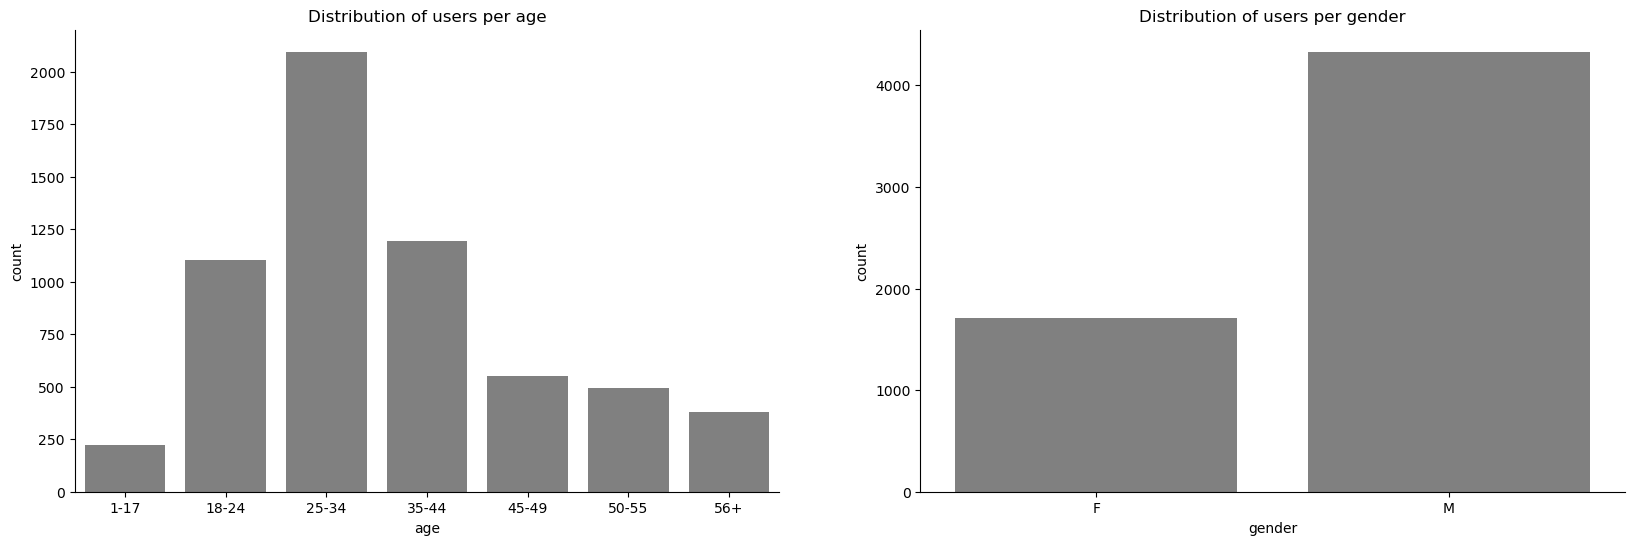

In [17]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of users per age')
sns.countplot(data=users, x='age', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('Distribution of users per gender')
sns.countplot(data=users, x='gender', color='grey', ax=ax[1])

## NDCG

In [78]:
def get_kruskal(ndcg_dicts, key_col):
    gender_list = list(ndcg_dicts[key_col].values())
    return stats.kruskal(*gender_list)

In [79]:
for c, ndcg_dict in ndcg_dicts.items():
    kruskal_val = get_kruskal(ndcg_dicts, c)
    print(f'Kruscal-Wallis test for {c}: {kruskal_val}')

Kruscal-Wallis test for age: KruskalResult(statistic=24.883809523809532, pvalue=0.00035878809622233443)
Kruscal-Wallis test for gender: KruskalResult(statistic=6.818181818181813, pvalue=0.009023438818080334)
Kruscal-Wallis test for usage: KruskalResult(statistic=33.33333333333334, pvalue=9.045386293179479e-06)


### By age and gender

In [103]:
def get_df_from_eval_dict(ndcg_dicts, key_col, eval_col='ndcg'):
    df_ndcg = pd.DataFrame(ndcg_dicts[key_col])
    df_ndcg = df_ndcg.melt()
    df_ndcg.columns = [key_col, eval_col]
    return df_ndcg

In [104]:
df_ndcg_age = get_df_from_eval_dict(ndcg_dicts, 'age')
df_ndcg_gender = get_df_from_eval_dict(ndcg_dicts, 'gender')

<AxesSubplot: title={'center': 'NDCG distribution for users grouped by gender'}, xlabel='gender', ylabel='ndcg'>

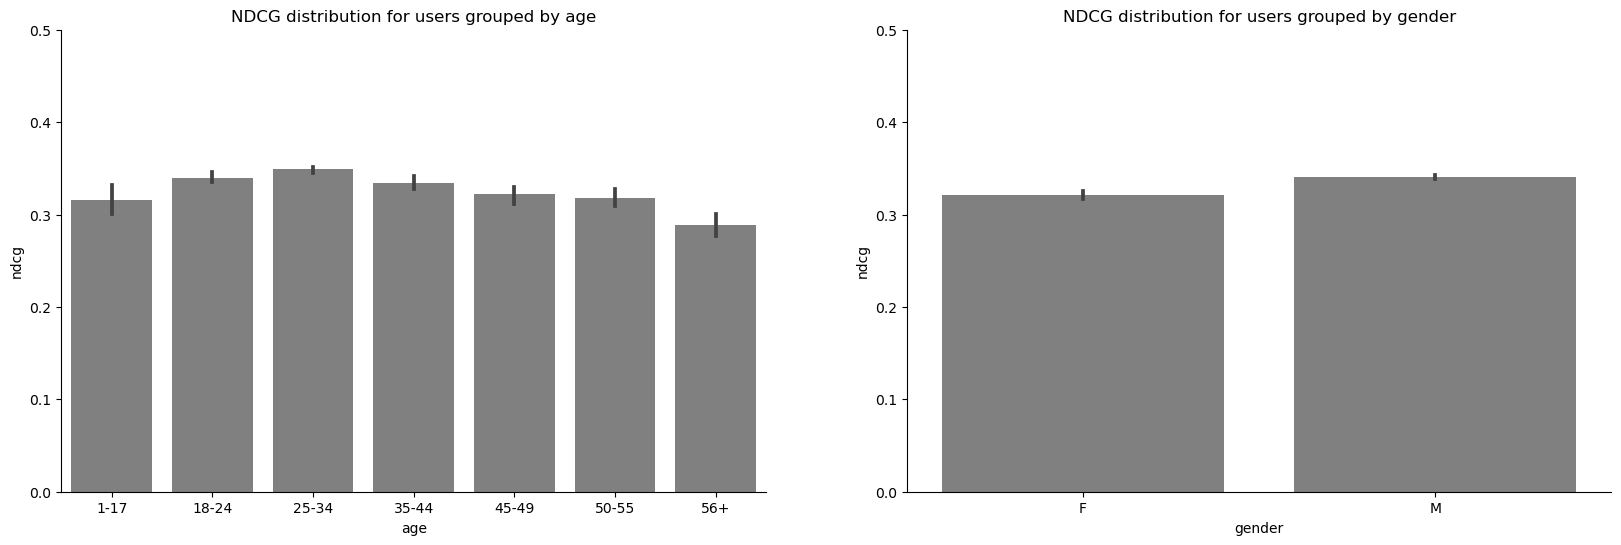

In [83]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('NDCG distribution for users grouped by age')
ax[0].set_ylim((0, 0.5))
sns.barplot(data=df_ndcg_age, x='age', y='ndcg', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('NDCG distribution for users grouped by gender')
ax[1].set_ylim((0, 0.5))
sns.barplot(data=df_ndcg_gender, x='gender', y='ndcg', color='grey', ax=ax[1])

In [110]:
df_ebm_age = get_df_from_eval_dict(ebm_dicts, 'age', 'ebm_score')
df_ebm_gender = get_df_from_eval_dict(ebm_dicts, 'gender', 'ebm_score')

<AxesSubplot: title={'center': 'EBM distribution for users grouped by gender'}, xlabel='gender', ylabel='ebm_score'>

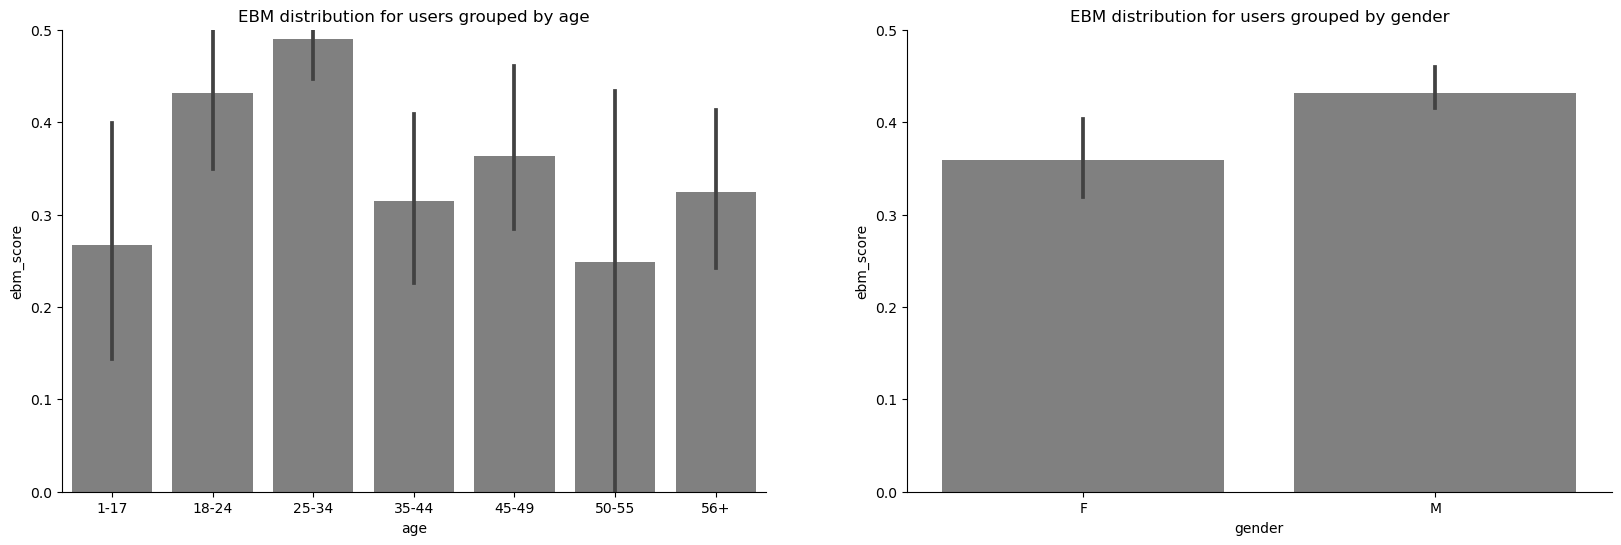

In [111]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('EBM distribution for users grouped by age')
ax[0].set_ylim((0, 0.5))
sns.barplot(data=df_ebm_age, x='age', y='ebm_score', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('EBM distribution for users grouped by gender')
ax[1].set_ylim((0, 0.5))
sns.barplot(data=df_ebm_gender, x='gender', y='ebm_score', color='grey', ax=ax[1])

### By usage

In [84]:
df_ndcg_usage = get_df_from_eval_dict(ndcg_dicts, 'usage')

<AxesSubplot: title={'center': 'NDCG distribution for users grouped by usage'}, xlabel='usage', ylabel='ndcg'>

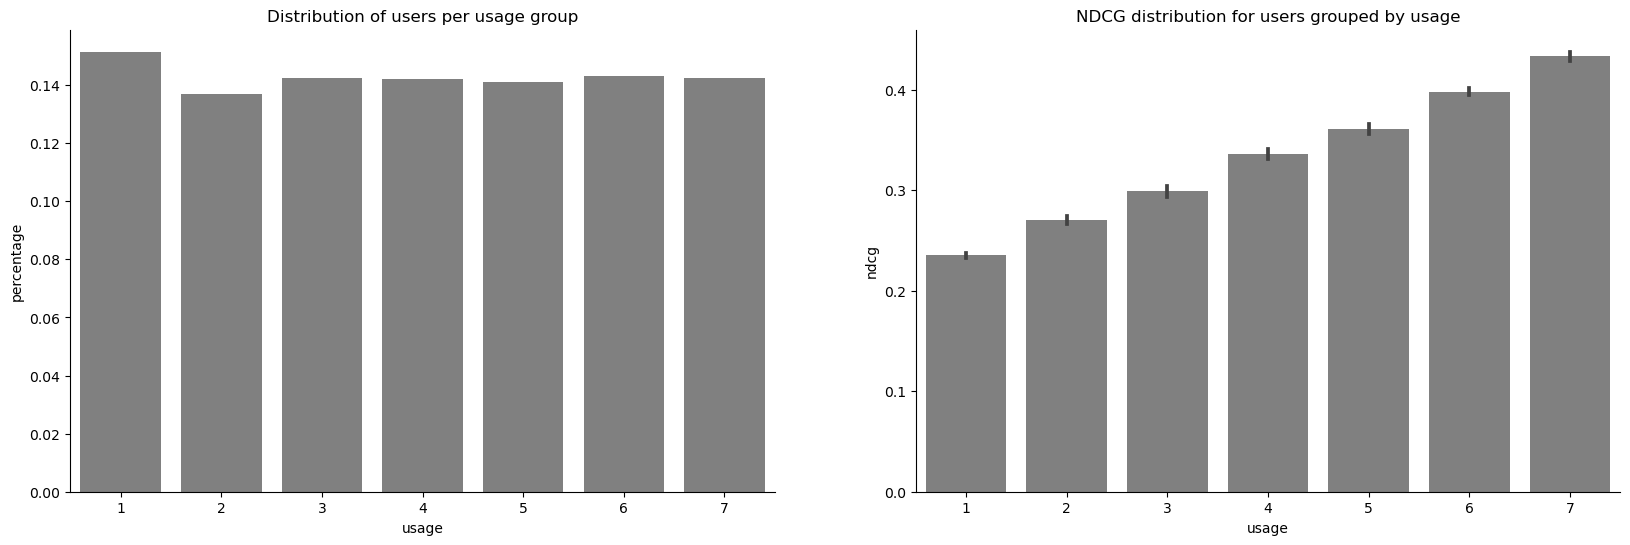

In [85]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of users per usage group')
sns.barplot(data=popularity_cut_counts, x='usage', y='percentage', color='grey', ax=ax[0], )

ax[1].set_title('NDCG distribution for users grouped by usage')
sns.barplot(data=df_ndcg_usage, x='usage', y='ndcg', color='grey', ax=ax[1])

In [112]:
df_ebm_usage = get_df_from_eval_dict(ebm_dicts, 'usage', 'ebm_score')

<AxesSubplot: title={'center': 'EBM distribution for users grouped by usage'}, xlabel='usage', ylabel='ebm_score'>

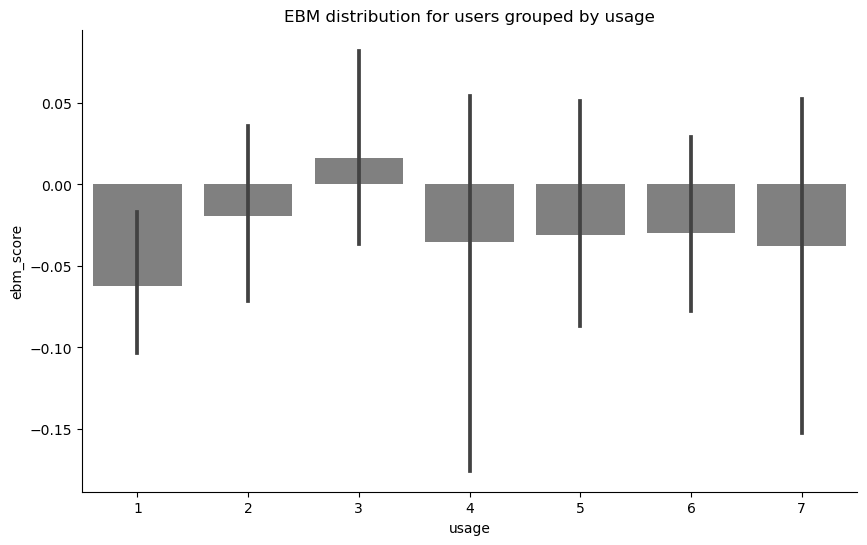

In [115]:
_, ax = plt.subplots(figsize=(10, 6))
sns.despine()

ax.set_title('EBM distribution for users grouped by usage')
sns.barplot(data=df_ebm_usage, x='usage', y='ebm_score', color='grey', ax=ax)